# Relate zonal SST gradient to changes in ENSO variance

In [61]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import numpy as np
# from scipy.io import netcdf
# import scipy.stats as stats
import pandas as pd

import xarray as xr
# import random
import os
from pprint import pprint
from tqdm import tqdm

## Basic information for reading in data

In [71]:
# directories with processed output
basedir_processed_MMLEA = '/glade/scratch/milinski/SMILEs/'

# directory for saving plots
plotdir = '/glade/scratch/samantha/plots/ENSOworkshop/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
    
# directories with processed output
# NINO3.4: from Sebastian
basedir_processed_NINO34 = '/glade/scratch/milinski/ESGF_downloads/NINO34/'

# SST fields: from Robb
basedir_regrid_SST = '/glade/scratch/rwills/cmip6_ensembles/'

# colors for plots
cols=['blue','red','black']


### Read in time series and SST fields

In [63]:
# Find which models have SST fields
models = [f for f in os.listdir(basedir_regrid_SST) if not f.startswith(('.','model_variants','native_grid','unsorted'))]
print(models)

# See which of those also have NINO3.4 time series calculated
nmodels = [f for f in os.listdir(basedir_processed_NINO34) if not f.startswith(('.','README','b.e21','unsorted'))]
print(nmodels)

['ec-earth3_lens', 'ukesm1_lens', 'giss_e21h_lens', 'cnrm_cm6_lens', 'miroc6_lens', 'norcpm1_lens', 'cesm2_lens', 'canesm5_lens', 'access_lens', 'giss_e21g_lens', 'miroc_esm2l_lens', 'ipsl_cm6a_lens']
['IPSL-CM6A-LR', 'CanESM5', 'CESM2-LENS', 'CNRM-CM6-1', 'MIROC6']


From this, I conclude that CanESM5, CESM2, and MIROC6 can be used. Specifying this manually:

In [64]:
mods=['canesm5_lens','cesm2_lens','miroc6_lens']
modscaps=['CanESM5','CESM2-LENS','MIROC6']

Now doing the actual reading in of the data!

In [101]:
ens_n34std=[]
ens_zdiff=[]

for m in tqdm(range(len(mods))):
    
    print(m)
    hep=[]
    hwp=[]
    hn34=[]    
    sspep=[]
    sspwp=[]
    sspn34=[]

    if not "cesm2" in mods[m]:
        moddir=basedir_regrid_SST+mods[m]+'/Omon/tos/'
        moddirssp=moddir
        f=os.listdir(basedir_regrid_SST+mods[m]+'/Omon/tos/')
        
        if "canesm5" in mods[m]:
            hfiles=[h for h in f if "historical" in h and "p1" in h]
        else:
            hfiles=[h for h in f if "historical" in h]
    else:
        moddir=basedir_regrid_SST+mods[m]+'/lens_mergetime_regrid/historical/SST/'
        moddirssp=basedir_regrid_SST+mods[m]+'/lens_mergetime_regrid/ssp370/SST/'
        n34dir1=basedir_processed_NINO34+modscaps[m]+"/BHISTcmip6/"
        n34dir2=basedir_processed_NINO34+modscaps[m]+"/BHISTsmbb/"
        f=os.listdir(basedir_regrid_SST+mods[m]+'/lens_mergetime_regrid/historical/SST/')
        hfiles=[h for h in f if "b.e21" in h and not "LE2-1191" in h]
                
    for hf in hfiles:
        # READ IN HISTORICAL DATA
        if not "cesm2" in mods[m]:
            mytos=xr.open_dataset(moddir+hf).tos.squeeze()
        else:
            mytos=xr.open_dataset(moddir+hf).SST.squeeze()
        # Eastern Pacific
        mask_lon = (mytos.lon >= 210) & (mytos.lon <= 270)
        mask_lat = (mytos.lat >= -5) & (mytos.lat <= 5)
        hep.append(mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze())
        
        # Western Pacific
        mask_lon = (mytos.lon >= 120) & (mytos.lon <= 180)
        hwp.append(mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze())
        
        # NINO3.4 
        mask_lon = (mytos.lon >= 190) & (mytos.lon <= 240)
        mask_lat = (mytos.lat >= -5) & (mytos.lat <= 5)
        hn34.append(mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze())

    # READ IN SSP DATA
                     
    for hf in hfiles:
        # Determine new filename based on ensemble member number from historical period
        if not "cesm2" in mods[m]:
            if "canesm5" in mods[m]:
                txt=hf.split("_")
                mem=txt[4] 
                hfssp='tos_mon_'+modscaps[m]+'_ssp370_'+mem+'_g025.nc'
            else:
                txt=hf.split("_")
                mem=txt[4] 
                hfssp='tos_mon_'+modscaps[m]+'_ssp585_'+mem+'_g025.nc'
        else:
            hftmp=hf.replace('HIST','SSP370')
            hfssp=hftmp.replace('185001-201412','201501-210012')

        if not "cesm2" in mods[m]:
            mytos=xr.open_dataset(moddirssp+hfssp).tos.squeeze()
        else:
            mytos=xr.open_dataset(moddirssp+hfssp).SST.squeeze()
        # Eastern Pacific
        mask_lon = (mytos.lon >= 210) & (mytos.lon <= 270)
        mask_lat = (mytos.lat >= -5) & (mytos.lat <= 5)
        sspep.append(mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze())
        
        # Western Pacific
        mask_lon = (mytos.lon >= 120) & (mytos.lon <= 180)
        sspwp.append(mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze())
        
        # NINO3.4 
        mask_lon = (mytos.lon >= 190) & (mytos.lon <= 240)
        mask_lat = (mytos.lat >= -5) & (mytos.lat <= 5)
        sspn34.append(mytos.where(mask_lon & mask_lat, drop=True).mean('lat').mean('lon').squeeze())
    
        
    # Remove ensemble mean from NINO3.4, to allow computation of variance
    ens_hep=xr.concat(hep,dim='member')
    ens_hwp=xr.concat(hwp,dim='member')
    ens_hn34=xr.concat(hn34,dim='member')
    
    ens_sspep=xr.concat(sspep,dim='member')
    ens_sspwp=xr.concat(sspwp,dim='member')
    ens_sspn34=xr.concat(sspn34,dim='member')
    
    ens_hn34=ens_hn34-ens_hn34.mean('member')
    ens_sspn34=ens_sspn34-ens_sspn34.mean('member')
    
    # Select appropriate years
    #plttime = ens_hn34.indexes['time'].to_datetimeindex()

    # Calculate differences
    ens_n34std.append(ens_sspn34.std('time').squeeze() - ens_hn34.std('time').squeeze())
    hzdiff=ens_hwp.mean('time')-ens_hep.mean('time').squeeze()
    sspzdiff=ens_sspwp.mean('time')-ens_sspep.mean('time').squeeze()
    
    ens_zdiff.append(sspzdiff - hzdiff)
    

  0%|          | 0/3 [00:00<?, ?it/s]

0


 33%|███▎      | 1/3 [00:22<00:44, 22.31s/it]

1
b.e21.BSSP370smbb.f09_g17.LE2-1251.015.cam.h0.SST.185001-201412.nc
b.e21.BSSP370cmip6.f09_g17.LE2-1041.003.cam.h0.SST.185001-201412.nc
b.e21.BSSP370smbb.f09_g17.LE2-1231.014.cam.h0.SST.185001-201412.nc
b.e21.BSSP370cmip6.f09_g17.LE2-1251.007.cam.h0.SST.185001-201412.nc
b.e21.BSSP370cmip6.f09_g17.LE2-1021.002.cam.h0.SST.185001-201412.nc
b.e21.BSSP370cmip6.f09_g17.LE2-1251.003.cam.h0.SST.185001-201412.nc
b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.cam.h0.SST.185001-201412.nc
b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.SST.185001-201412.nc
b.e21.BSSP370cmip6.f09_g17.LE2-1251.001.cam.h0.SST.185001-201412.nc
b.e21.BSSP370smbb.f09_g17.LE2-1281.019.cam.h0.SST.185001-201412.nc
b.e21.BSSP370cmip6.f09_g17.LE2-1281.010.cam.h0.SST.185001-201412.nc
b.e21.BSSP370smbb.f09_g17.LE2-1231.016.cam.h0.SST.185001-201412.nc
b.e21.BSSP370smbb.f09_g17.LE2-1171.009.cam.h0.SST.185001-201412.nc
b.e21.BSSP370smbb.f09_g17.LE2-1301.017.cam.h0.SST.185001-201412.nc
b.e21.BSSP370smbb.f09_g17.LE2-1251.018.cam.h0.SST.185

 67%|██████▋   | 2/3 [01:41<00:55, 55.69s/it]

2


100%|██████████| 3/3 [02:18<00:00, 46.26s/it]


Now go through and plot the results!!

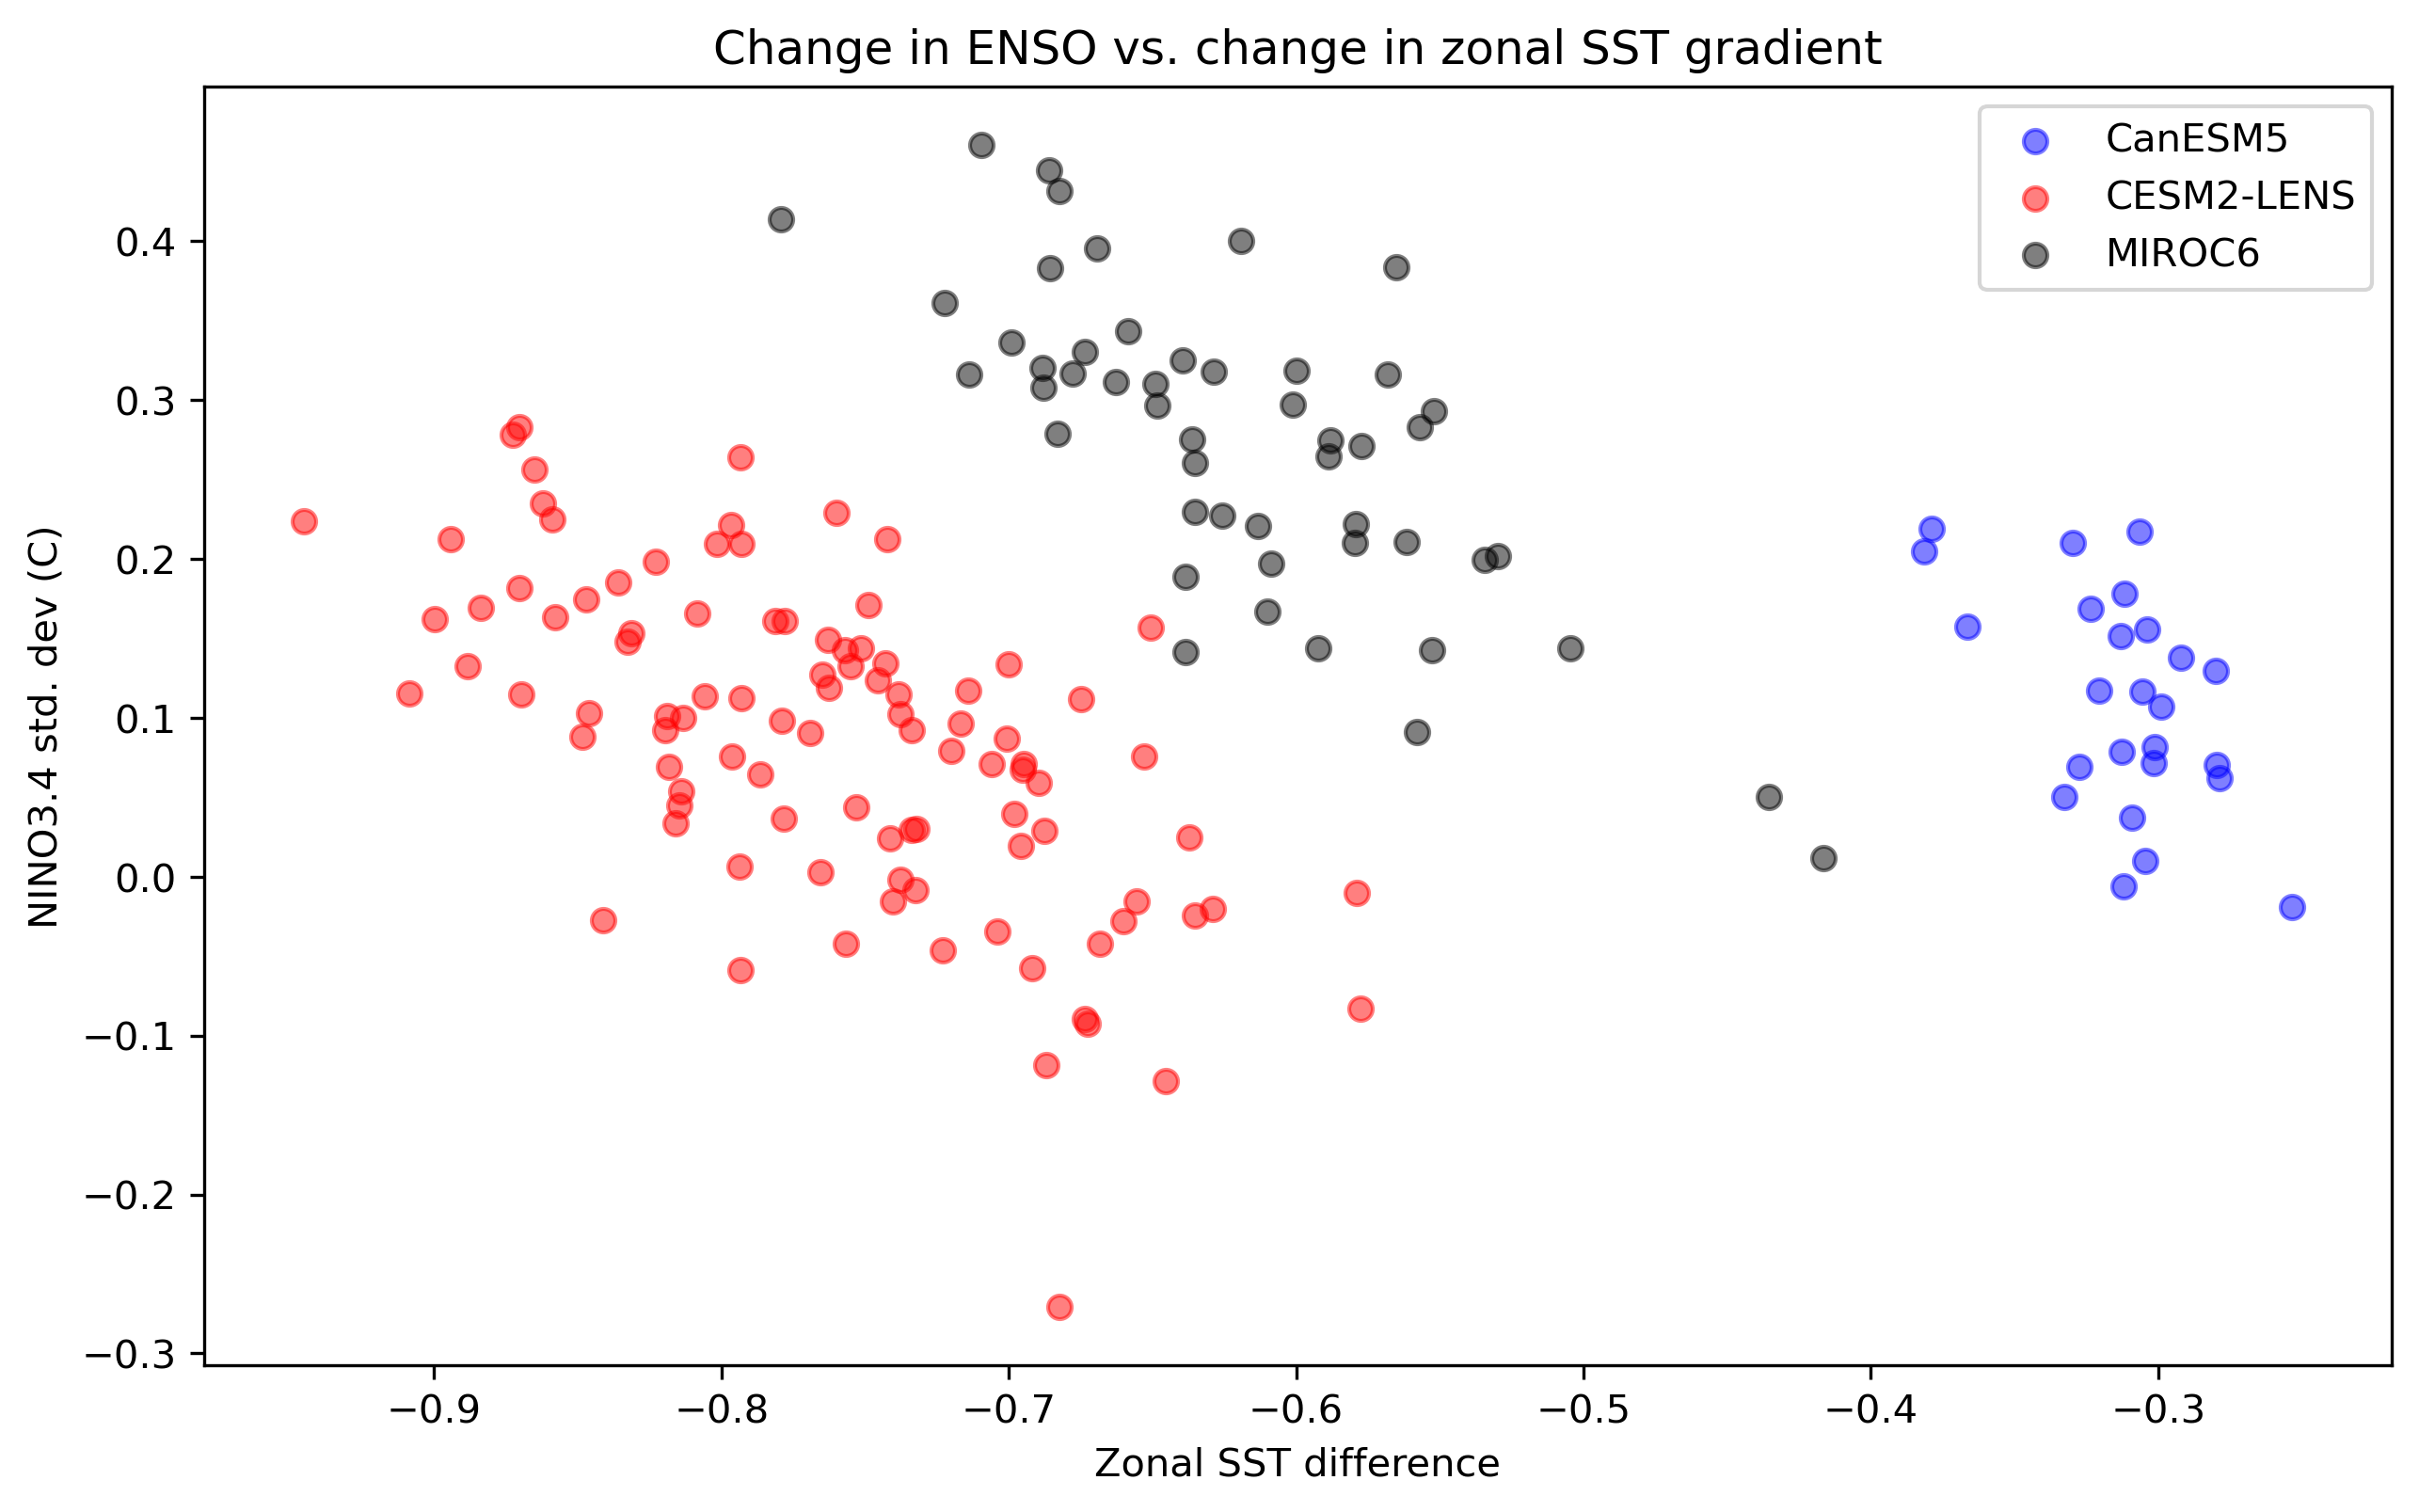

In [102]:
plt.figure(figsize=(10, 6), dpi=300)

for m in range(len(mods)):
    plt.scatter(ens_zdiff[m], ens_n34std[m], c=cols[m], alpha=0.5)
        
plt.title('Change in ENSO vs. change in zonal SST gradient')
plt.ylabel('NINO3.4 std. dev (C)')
plt.xlabel('Zonal SST difference')

plt.legend(modscaps)

plt.savefig(plotdir+'delenso_vdelzonalgrad_cmip6.pdf', bbox_inches='tight', dpi=300)

In [103]:
#plttime = ens_hn34.indexes['time'].to_datetimeindex()
#print(plttime)